In [3]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tf.__version__

'2.11.0'

# 构建几何图形

In [31]:
from geomdl import NURBS
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import numpy as np
class Geometry2D:
    '''
     Base class for 2D domains
     Input: geomData - dictionary containing the geomety information
     Keys: degree_u, degree_v: polynomial degree in the u and v directions
       ctrlpts_size_u, ctrlpts_size_v: number of control points in u,v directions
       ctrlpts: weighted control points (in a list with 
            ctrlpts_size_u*ctrlpts_size_v rows and 3 columns for x,y,z coordinates)
       weights: correspond weights (list with ctrlpts_size_u*ctrlpts_size_v entries)
       knotvector_u, knotvector_v: knot vectors in the u and v directions
    '''
    def __init__(self, geomData):
        self.surf = NURBS.Surface()
        self.surf.degree_u = geomData['degree_u']
        self.surf.degree_v = geomData['degree_v']
        self.surf.ctrlpts_size_u = geomData['ctrlpts_size_u']
        self.surf.ctrlpts_size_v = geomData['ctrlpts_size_v']
        self.surf.ctrlpts = self.getUnweightedCpts(geomData['ctrlpts'], 
                                             geomData['weights'])
        self.surf.weights = geomData['weights']
        self.surf.knotvector_u = geomData['knotvector_u']
        self.surf.knotvector_v = geomData['knotvector_v']                
        
    def getUnweightedCpts(self, ctrlpts, weights):
        numCtrlPts = np.shape(ctrlpts)[0]
        PctrlPts = np.zeros_like(ctrlpts)
        for i in range(3):
            for j in range(numCtrlPts):
                PctrlPts[j,i]=ctrlpts[j][i]/weights[j]
        PctrlPts = PctrlPts.tolist()
        return PctrlPts
        
    def mapPoints(self, uPar, vPar):
        '''
        Map points from the parameter domain [0,1]x[0,1] to the quadrilater domain
        Input:  uPar - array containing the u-coordinates in the parameter space
                vPar - array containing the v-coordinates in the parameter space
                Note: the arrays uPar and vPar must be of the same size
        Output: xPhys - array containing the x-coordinates in the physical space
                yPhys - array containing the y-coordinates in the physical space
        '''        
        gpParamUV = np.array([uPar, vPar])
        evalList = tuple(map(tuple, gpParamUV.transpose()))
        res = np.array(self.surf.evaluate_list(evalList))
                
        return res
    
    def getUnifIntPts(self, numPtsU, numPtsV, withEdges):
        '''
        在域内生成间距均匀的点
        这个 numPtsU, numPtsV 是 在各个方向生成点的数量
        withEdges : 表示是否在边界点生成[底、右、上、左] 0 no 1 Yes
        '''
        '''
        Generate uniformly spaced points inside the domain
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               withEdges - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xPhys, yPhys - flattened array containing the x and y coordinates of the points
        '''
        #generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)
        
        #remove endpoints depending on values of withEdges
        if withEdges[0]==0:
            vEdge = vEdge[1:]
        if withEdges[1]==0:
            uEdge = uEdge[:-1]
        if withEdges[2]==0:
            vEdge = vEdge[:-1]
        if withEdges[3]==0:
            uEdge = uEdge[1:]
            
        #create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)        
                        
        uPar = uPar.flatten()
        vPar = vPar.flatten()     
        #map points
        res = self.mapPoints(uPar.T, vPar.T)
        
        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]
        
        return xPhys, yPhys
    
    def compNormals(self, uPts, vPts, orientPts):
        '''
        computes the normals of the points on the boundary

        Parameters
        ----------
        uPts, vPts : arrays containing the u and v coordinates of the boundary points            
        orientPts: array containing the orientation in parameter space: 1 is down (v=0), 
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)

        Returns
        -------
        xyNorm : array containing the x and y components of the outer normal vectors

        '''        
        numPts = len(uPts)
        xyNorm = np.zeros((numPts, 2))
        for iPt in range(numPts):
            curPtU = uPts[iPt]
            curPtV = vPts[iPt]
            derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
           
            #physPtX = derivMat[0][0][0]
            #physPtY = derivMat[0][0][1]

            derivU = derivMat[1][0][0:2]
            derivV = derivMat[0][1][0:2]
            JacobMat = np.array([derivU,derivV])

            if orientPts[iPt]==1:
                xNorm = JacobMat[0,1]
                yNorm = -JacobMat[0,0]
            elif orientPts[iPt]==2:
                xNorm = JacobMat[1,1]
                yNorm = -JacobMat[1,0]
            elif orientPts[iPt]==3:
                xNorm = -JacobMat[0,1]
                yNorm = JacobMat[0,0]
            elif orientPts[iPt]==4:
                xNorm = -JacobMat[1,1]
                yNorm = JacobMat[1,0]
            else:
                raise Exception('Wrong orientation given')
                
            JacobEdge = np.sqrt(xNorm**2+yNorm**2)
            xNorm = xNorm/JacobEdge
            yNorm = yNorm/JacobEdge

            xyNorm[iPt,0] = xNorm
            xyNorm[iPt,1] = yNorm
        
        return xyNorm
    
    def getUnifEdgePts(self, numPtsU, numPtsV, edgeIndex):
        '''
        Generate uniformly spaced points on the edge boundaries
        Input: numPtsU, numPtsV - number of points (including edges) in the u and v
                   directions in the parameter space
               edgeIndex - 1x4 array of zeros or ones specifying whether the boundary points
                           should be included. The boundary order is [bottom, right,
                           top, left] for the unit square.
        Output: xPhys, yPhys - flattened array containing the x and y coordinates of the points
                xNorm, yNorm - arrays containing the x and y component of the outer normal vectors
        '''
        #generate points in the x direction on the interval [0,1]
        uEdge = np.linspace(0, 1, numPtsU)
        vEdge = np.linspace(0, 1, numPtsV)
        
        uPts = np.zeros(0)
        vPts = np.zeros(0)
        orientPts = np.zeros(0)
        
        #remove endpoints depending on values of withEdges
        if edgeIndex[0]==1:
            uPts = np.concatenate((uPts, uEdge))
            vPts = np.concatenate((vPts, np.zeros((numPtsU))))
            orientPts = np.concatenate((orientPts, np.ones((numPtsU))))
        if edgeIndex[1]==1:
            uPts = np.concatenate((uPts, np.ones((numPtsV)))) 
            vPts = np.concatenate((vPts, vEdge))
            orientPts = np.concatenate((orientPts, 2*np.ones((numPtsV))))
        if edgeIndex[2]==1:
            uPts = np.concatenate((uPts, uEdge))
            vPts = np.concatenate((vPts, np.ones((numPtsU))))
            orientPts = np.concatenate((orientPts, 3*np.ones((numPtsU))))
        if edgeIndex[3]==1:
            uPts = np.concatenate((uPts, np.zeros((numPtsV))))
            vPts = np.concatenate((vPts, vEdge))
            orientPts = np.concatenate((orientPts, 4*np.ones((numPtsV))))
            
        #map points
        res = self.mapPoints(uPts, vPts)

        xyNorm = self.compNormals(uPts, vPts, orientPts)        
        xPhys = res[:, 0:1]
        yPhys = res[:, 1:2]
        xNorm = xyNorm[:, 0:1]
        yNorm = xyNorm[:, 1:2]
        
        return xPhys, yPhys, xNorm, yNorm
    
    def getQuadIntPts(self, numElemU, numElemV, numGauss):
        '''
        Generate quadrature points inside the domain
        Input: numElemU, numElemV - number of subdivisions in the u and v
                   directions in the parameter space
               numGauss - number of Gauss quadrature points for each subdivision
        Output: xPhys, yPhys, wgtPhy - arrays containing the x and y coordinates
                                    of the points and the corresponding weights
        '''
        #allocate quadPts array
        quadPts = np.zeros((numElemU*numElemV*numGauss**2, 3))
        
        #get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)
        
        #get the Gauss weights on the reference element [-1, 1]x[-1,1]
        gpWeightU, gpWeightV = np.meshgrid(gw, gw)
        gpWeightUV = np.array(gpWeightU.flatten()*gpWeightV.flatten())
        
        #generate the knots on the interval [0,1]
        uEdge = np.linspace(0, 1, numElemU+1)
        vEdge = np.linspace(0, 1, numElemV+1)            

        #create meshgrid
        uPar, vPar = np.meshgrid(uEdge, vEdge)              
                        
        #generate points for each element
        indexPt = 0
        for iV in range(numElemV):
            for iU in range(numElemU):
                uMin = uPar[iV, iU]
                uMax = uPar[iV, iU+1]
                vMin = vPar[iV, iU]
                vMax = vPar[iV+1, iU]
                gpParamU = (uMax-uMin)/2*gp+(uMax+uMin)/2
                gpParamV = (vMax-vMin)/2*gp+(vMax+vMin)/2
                gpParamUg, gpParamVg = np.meshgrid(gpParamU, gpParamV)
                gpParamUV = np.array([gpParamUg.flatten(), gpParamVg.flatten()])
                #Jacobian of the transformation from the reference element [-1,1]x[-1,1]
                scaleFac = (uMax-uMin)*(vMax-vMin)/4
                
                #map the points to the physical space
                for iPt in range(numGauss**2):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU,derivV])
                    detJac = np.linalg.det(JacobMat)
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = scaleFac * detJac * gpWeightUV[iPt]
                    indexPt = indexPt + 1
                            
        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        wgtPhys = quadPts[:, 2:3]
        
        return xPhys, yPhys, wgtPhys
    
    def getUnweightedCpts2d(self, ctrlpts2d, weights):
        numCtrlPtsU = np.shape(ctrlpts2d)[0]
        numCtrlPtsV = np.shape(ctrlpts2d)[1]
        PctrlPts = np.zeros([numCtrlPtsU,numCtrlPtsV,3])
        counter = 0    
        for j in range(numCtrlPtsU):
            for k in range(numCtrlPtsV):
                for i in range(3):
                    PctrlPts[j,k,i]=ctrlpts2d[j][k][i]/weights[counter]
                counter = counter + 1
        PctrlPts = PctrlPts.tolist()
        return PctrlPts
    
    
    def plotSurf(self):
        #plots the NURBS/B-Spline surface and the control points in 2D
        fig, ax = plt.subplots()
        patches = []
            
        #get the number of points in the u and v directions
        numPtsU = np.int(1/self.surf.delta[0])-1
        numPtsV = np.int(1/self.surf.delta[1])-1
        
        for j in range(numPtsV):
            for i in range(numPtsU):
                #get the index of point in the lower left corner of the visualization element
                indexPtSW = j*(numPtsU+1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, 
                                indexPtNE, indexPtNW],0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)
                
                
        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)
        
        numCtrlPtsU = self.surf._control_points_size[0]
        numCtrlPtsV = self.surf._control_points_size[1]
        ctrlpts = self.getUnweightedCpts2d(self.surf.ctrlpts2d, self.surf.weights)
        #plot the horizontal lines
        for j in range(numCtrlPtsU):
            plt.plot(np.array(ctrlpts)[j,:,0],np.array(ctrlpts)[j,:,1],ls='--',color='black')
        #plot the vertical lines
        for i in range(numCtrlPtsV):
            plt.plot(np.array(ctrlpts)[:,i,0],np.array(ctrlpts)[:,i,1],ls='--',color='black')
        #plot the control points
        plt.scatter(np.array(self.surf.ctrlpts)[:,0],np.array(self.surf.ctrlpts)[:,1],color='red',zorder=10)
        plt.axis('equal')
        
    def plotKntSurf(self):
        #plots the NURBS/B-Spline surface and the knot lines in 2D
        fig, ax = plt.subplots()
        patches = []
        
        #get the number of points in the u and v directions
        self.surf.delta = 0.02
        self.surf.evaluate()
        numPtsU = np.int(1/self.surf.delta[0])-1
        numPtsV = np.int(1/self.surf.delta[1])-1
        
        for j in range(numPtsV):
            for i in range(numPtsU):
                #get the index of point in the lower left corner of the visualization element
                indexPtSW = j*(numPtsU+1) + i
                indexPtSE = indexPtSW + 1
                indexPtNE = indexPtSW + numPtsU + 2
                indexPtNW = indexPtSW + numPtsU + 1
                XYPts = np.array(self.surf.evalpts)[[indexPtSW, indexPtSE, indexPtNE, indexPtNW],0:2]
                poly = mpatches.Polygon(XYPts)
                patches.append(poly)
                
        collection = PatchCollection(patches, color="lightgreen", cmap=plt.cm.hsv, alpha=1)
        ax.add_collection(collection)
        
        #plot the horizontal knot lines
        for j in np.unique(self.surf.knotvector_u):
            vVal = np.linspace(0, 1, numPtsV)
            uVal = np.ones(numPtsV)*j    
            uvVal = np.array([uVal, vVal])
            
            evalList=tuple(map(tuple, uvVal.transpose()))
            res=np.array(self.surf.evaluate_list(evalList))        
            plt.plot(res[:,0],res[:,1], ls='-', linewidth=1, color='black')
            
        #plot the vertical lines
        for i in np.unique(self.surf.knotvector_v):
            uVal = np.linspace(0, 1, numPtsU)
            vVal = np.ones(numPtsU)*i    
            uvVal = np.array([uVal, vVal])
            
            evalList=tuple(map(tuple, uvVal.transpose()))
            res=np.array(self.surf.evaluate_list(evalList))        
            plt.plot(res[:,0],res[:,1], ls='-', linewidth=1, color='black')
       
        plt.axis('equal')        
    
    def getQuadEdgePts(self, numElem, numGauss, orient):
        '''
        Generate points on the boundary edge given by orient
        Input: numElem - number of number of subdivisions (in the v direction)
               numGauss - number of Gauss points per subdivision
               orient - edge orientation in parameter space: 1 is down (v=0), 
                        2 is left (u=1), 3 is top (v=1), 4 is right (u=0)
        Output: xBnd, yBnd, wgtBnd - coordinates of the boundary in the physical
                                     space and the corresponding weights
                xNorm, yNorm  - x and y component of the outer normal vector
        '''
                #allocate quadPts array
        quadPts = np.zeros((numElem*numGauss, 5))
        
        #get the Gauss points on the reference interval [-1,1]
        gp, gw = np.polynomial.legendre.leggauss(numGauss)        
        
        #generate the knots on the interval [0,1]
        edgePar = np.linspace(0, 1, numElem+1)            
                        
        #generate points for each element
        indexPt = 0
        for iE in range(numElem):                
                edgeMin = edgePar[iE]
                edgeMax = edgePar[iE+1]
                if orient==1:
                    gpParamU = (edgeMax-edgeMin)/2*gp+(edgeMax+edgeMin)/2
                    gpParamV = np.zeros_like(gp)                    
                elif orient==2:
                    gpParamU = np.ones_like(gp)
                    gpParamV = (edgeMax-edgeMin)/2*gp+(edgeMax+edgeMin)/2
                elif orient==3:
                    gpParamU = (edgeMax-edgeMin)/2*gp+(edgeMax+edgeMin)/2
                    gpParamV = np.ones_like(gp)   
                elif orient==4:
                    gpParamU = np.zeros_like(gp)
                    gpParamV = (edgeMax-edgeMin)/2*gp+(edgeMax+edgeMin)/2
                else:
                    raise Exception('Wrong orientation given')
                        
                gpParamUV = np.array([gpParamU.flatten(), gpParamV.flatten()])
                
                #Jacobian of the transformation from the reference element [-1,1]
                scaleFac = (edgeMax-edgeMin)/2
                
                #map the points to the physical space
                for iPt in range(numGauss):
                    curPtU = gpParamUV[0, iPt]
                    curPtV = gpParamUV[1, iPt]
                    derivMat = self.surf.derivatives(curPtU, curPtV, order=1)
                    physPtX = derivMat[0][0][0]
                    physPtY = derivMat[0][0][1]
                    derivU = derivMat[1][0][0:2]
                    derivV = derivMat[0][1][0:2]
                    JacobMat = np.array([derivU,derivV])
                    if orient==1:                                                
                        normX = JacobMat[0,1]
                        normY = -JacobMat[0,0]
                    elif orient==2:
                        normX = JacobMat[1,1]
                        normY = -JacobMat[1,0]
                    elif orient==3:
                        normX = -JacobMat[0,1]
                        normY = JacobMat[0,0]
                    elif orient==4:
                        normX = -JacobMat[1,1]
                        normY = JacobMat[1,0]
                    else:
                        raise Exception('Wrong orientation given')
                        
                    JacobEdge = np.sqrt(normX**2+normY**2)
                    normX = normX/JacobEdge
                    normY = normY/JacobEdge
        
                    quadPts[indexPt, 0] = physPtX
                    quadPts[indexPt, 1] = physPtY
                    quadPts[indexPt, 2] = normX
                    quadPts[indexPt, 3] = normY
                    quadPts[indexPt, 4] = scaleFac * JacobEdge * gw[iPt]
                    indexPt = indexPt + 1
                            
        xPhys = quadPts[:, 0:1]
        yPhys = quadPts[:, 1:2]
        xNorm = quadPts[:, 2:3]
        yNorm = quadPts[:, 3:4]
        wgtPhys = quadPts[:, 4:5]        
        
        return xPhys, yPhys, xNorm, yNorm, wgtPhys

In [32]:
class Quadrilateral(Geometry2D):
    '''
     Class for definining a quadrilateral domain
     Input: quadDom - array of the form [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
                containing the domain corners (control-points)
    '''
    def __init__(self, quadDom):
      
        # Domain vertices
        self.quadDom = quadDom # 存储传入的四边形顶点坐标
        
        self.x1, self.y1 = self.quadDom[0,:]
        self.x2, self.y2 = self.quadDom[1,:]
        self.x3, self.y3 = self.quadDom[2,:]
        self.x4, self.y4 = self.quadDom[3,:]
        
        geomData = dict()
        
        # Set degrees
        geomData['degree_u'] = 1
        geomData['degree_v'] = 1
        
        # Set control points
        geomData['ctrlpts_size_u'] = 2
        geomData['ctrlpts_size_v'] = 2
                
        geomData['ctrlpts'] = [[self.x1, self.y1, 0], [self.x2, self.y2, 0],
                        [self.x3, self.y3, 0], [self.x4, self.y4, 0]]
        
        geomData['weights'] = [1., 1., 1., 1.]
        
        # Set knot vectors
        geomData['knotvector_u'] = [0.0, 0.0, 1.0, 1.0]
        geomData['knotvector_v'] = [0.0, 0.0, 1.0, 1.0]
        super().__init__(geomData)

# 绘图

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 21 15:39:44 2020

@author: cosmin
"""
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_pts(Xint, Xbnd):
    '''
    Plots the collcation points from the interior and boundary

    Parameters
    ----------
    Xint : TYPE
        DESCRIPTION.
    Xbnd : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    '''
     #plot the boundary and interior points
    plt.scatter(Xint[:,0], Xint[:,1], s=0.5)
    plt.scatter(Xbnd[:,0], Xbnd[:,1], s=1, c='red')
    plt.title("Boundary and interior collocation points")
    plt.show()
    
    
def plot_solution(numPtsUTest, numPtsVTest, domain, pred_model, data_type):
    xPhysTest, yPhysTest = domain.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
    XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
    XTest_tf = tf.convert_to_tensor(XTest)
    YTest = pred_model(XTest_tf).numpy()    
   # YExact = exact_sol(XTest[:,[0]], XTest[:,[1]])

    xPhysTest2D = np.resize(XTest[:,0], [numPtsUTest, numPtsVTest])
    yPhysTest2D = np.resize(XTest[:,1], [numPtsUTest, numPtsVTest])
    #YExact2D = np.resize(YExact, [numPtsUTest, numPtsVTest])
    YTest2D = np.resize(YTest, [numPtsUTest, numPtsVTest])
    # plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D, 255, cmap=plt.cm.jet)
    # plt.colorbar()
    # plt.title("Exact solution")
    # plt.show()
    plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Computed solution")
    plt.show()


def plot_solution_2d_elast(numPtsUTest, numPtsVTest, domain, pred_model, data_type):
    xPhysTest, yPhysTest = domain.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
    XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
    XTest_tf = tf.convert_to_tensor(XTest)
    YTest = pred_model(XTest_tf).numpy()    
   # YExact = exact_sol(XTest[:,[0]], XTest[:,[1]])

    xPhysTest2D = np.resize(XTest[:,0], [numPtsUTest, numPtsVTest])
    yPhysTest2D = np.resize(XTest[:,1], [numPtsUTest, numPtsVTest])
    #YExact2D = np.resize(YExact, [numPtsUTest, numPtsVTest])
    YTest2D = np.resize(YTest, [numPtsUTest, numPtsVTest])
    # plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D, 255, cmap=plt.cm.jet)
    # plt.colorbar()
    # plt.title("Exact solution")
    # plt.show()
    plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title("Computed solution")
    plt.show()
    
def plot_field_2d(Xpts, Ypts, numPtsU, numPtsV, title=""):
    '''
    Plots a field in 2D

    Parameters
    ----------
    Xpts : nx2 array containing the x and y coordinates of the points on a grid
    YPts : nx1 array containing the value to be plotted at each point
    numPtsU : scalar
                number of points in the U-parametric direction of the grid
    numPtsV : scalar
                number of points in the V-parametric direction of the grid
    title : string, optional
        The title of the plot. The default is "".

    Returns
    -------
    None.

    '''
    xPtsPlt = np.resize(Xpts[:,0], [numPtsV, numPtsU])
    yPtsPlt = np.resize(Xpts[:,1], [numPtsV, numPtsU])
    fieldPtsPlt = np.resize(Ypts, [numPtsV, numPtsU])
    plt.contourf(xPtsPlt, yPtsPlt, fieldPtsPlt, 255, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title(title)
    plt.show()
    
def plot_convergence_semilog(adam_loss_hist, bfgs_loss_hist):
    '''
    Plots the convergence of the loss function for the collocation method. The 
    plot uses log scale for the y-axis.

    Parameters
    ----------
    adam_loss_hist : (list of floats)
        the loss at each iteration of the Adam optimizer
    bfgs_loss_hist : (list of floats)
        the loss at each iteration of the BFGS optimizer

    Returns
    -------
    None.

    '''
    num_epoch = len(adam_loss_hist)
    num_iter_bfgs = len(bfgs_loss_hist)
    plt.semilogy(range(num_epoch), adam_loss_hist, label='Adam')
    plt.semilogy(range(num_epoch, num_epoch+num_iter_bfgs), bfgs_loss_hist, 
                 label = 'BFGS')
    plt.legend()
    plt.title('Loss convergence')
    plt.show()
    
def plot_convergence_dem(adam_loss_hist, bfgs_loss_hist, percentile=99., 
                         folder = None, file = None):
    '''
    Plots the convergence of the loss function for the Deep Energy Method. The
    values higher than the "percentile" parameter are ignored.

    Parameters
    ----------
    adam_loss_hist : (list of floats)
        the loss at each iteration of the Adam optimizer
    bfgs_loss_hist : (list of floats)
        the loss at each iteration of the BFGS optimizer
    percentile : (float)
        . The default is 99.

    Returns
    -------
    None.

    '''
    num_epoch = len(adam_loss_hist)
    num_iter_bfgs = len(bfgs_loss_hist)
    loss_hist_all = adam_loss_hist + bfgs_loss_hist
    y_max = np.percentile(loss_hist_all, percentile)
    y_min = np.min(loss_hist_all)
    plt.ylim(y_min, y_max)
    plt.plot(range(num_epoch), np.minimum(adam_loss_hist, y_max) , label='Adam')
    plt.plot(range(num_epoch, num_epoch+num_iter_bfgs), np.minimum(bfgs_loss_hist, y_max), 
                 label = 'BFGS')
    plt.legend()
    plt.title('Loss convergence')
    if folder != None:
        full_name = folder + '/' + file
        plt.savefig(full_name)
    plt.show()



# L-BFGS

In [34]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 11 15:50:38 2020

@author: cosmin
"""
import tensorflow as tf
import numpy as np

def tfp_function_factory(model, *args):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Based on the example from https://pychao.com/2019/11/02/optimize-tensorflow-keras-models-with-l-bfgs-from-tensorflow-probability/
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        *args: arguments to be passed to model.get_grads method        
        
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.prod(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)
    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.

        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.

        This function is created by function_factory.

        Args:
           params_1d [in]: a 1D tf.Tensor.

        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        assign_new_model_parameters(params_1d)        
        loss_value, grads = model.get_grad(*args)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        if f.iter%model.print_epoch == 0:
            tf.print("Iter:", f.iter, "loss:", loss_value)
        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])
        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

# Test_1 复现Demo

In [35]:
tf.random.set_seed(42)
data_type = "float64"

cycle_number = 0

# parameters set
omiga = 3.497e-6
nu = 0.3
D1 = 7.08e-15
D2 = 1e-14
E1 = 1e10
E2 = 4e9
R1 = 8e-7
j = 1e-3
R = 8.3145
T = 300
R2 = 4e-7
alfa = j*R1*omiga/D1
theta1=omiga*E1/(R*T*3.0*0.4)
theta2=omiga*E2/(R*T*3.0*0.4)
D_divide = D2/D1
E_divide = E2/E1

In [36]:
# 定义总长度
xmin = 0.5
xmax = 1.0
tmin = 0.0
tmax = 1.0

delta = 0.05  # 定义间隔

# 区域1
area_1_xmin = 0.5
area_1_xmax = 0.75

# 区域2
area_2_xmin = 0.75 + delta
area_2_xmax = 1.0  + delta

# 区域1 
domainCorners_area_1 = np.array([[area_1_xmin, tmin], [area_1_xmin, tmax], [
                                area_1_xmax, tmin], [area_1_xmax, tmax]])
domainGeom_area_1 = Quadrilateral(domainCorners_area_1)
#区域2
domainCorners_area_2 = np.array([[area_2_xmin, tmin], [area_2_xmin, tmax], [
                                area_2_xmax, tmin], [area_2_xmax, tmax]])
domainGeom_area_2 = Quadrilateral(domainCorners_area_2)

# train point 
numPtsU = 10
numPtsV = 10
numGauss = 4

'''
    设置区域1的训练点
'''
# 区域1域内
xPhys_1, yPhys_1, Wint_1 = domainGeom_area_1.getQuadIntPts(
    numPtsU, numPtsV, numGauss)  # in area 1
Xint_1 = np.concatenate((xPhys_1, yPhys_1), axis=1).astype(data_type)
Yint_1 = np.zeros_like(xPhys_1).astype(data_type) # 源项值
Wint_1 = Wint_1.astype(data_type)
# 区域1左边界
xPhysBnd_1, yPhysBnd_1, _, _ = domainGeom_area_1.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [0, 0, 0, 1])
Xbnd_area_1 = np.concatenate((xPhysBnd_1, yPhysBnd_1), axis=1).astype(data_type)
Ybnd_area_1 = np.zeros_like(Xbnd_area_1).astype(data_type)
# 区域1界面
xPhysInf_1, yPhysInf_1, _, _ = domainGeom_area_1.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [0, 1, 0, 0])
XInf_area_1 = np.concatenate((xPhysInf_1, yPhysInf_1), axis=1).astype(data_type)
# 区域1初始条件
xPhysInit_1, yPhysInit_1, _, _ = domainGeom_area_1.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [1, 0, 0, 0])
Xinit_area_1 = np.concatenate((xPhysInit_1, yPhysInit_1), axis=1).astype(data_type)
Yinit_area_1 = np.zeros_like(Xinit_area_1).astype(data_type)
'''
    设置区域2的训练点
'''
# 区域2域内
xPhys_2, yPhys_2, Wint_2 = domainGeom_area_2.getQuadIntPts(
    numPtsU, numPtsV, numGauss)  # in area 2
Xint_2 = np.concatenate((xPhys_2, yPhys_2), axis=1).astype(data_type)
Yint_2 = np.zeros_like(xPhys_2).astype(data_type) # 源项值
Wint_2 = Wint_2.astype(data_type)
# 区域2右边界
xPhysBnd_2, yPhysBnd_2, _, _ = domainGeom_area_2.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [0, 1, 0, 0])
Xbnd_area_2 = np.concatenate((xPhysBnd_2, yPhysBnd_2), axis=1).astype(data_type)
Ybnd_area_2 = np.ones_like(Xbnd_area_2).astype(data_type)
# 区域2界面
xPhysInf_2, yPhysInf_2, _, _ = domainGeom_area_2.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [0, 0, 0, 1])
XInf_area_2 = np.concatenate((xPhysInf_2, yPhysInf_2), axis=1).astype(data_type)
# 区域2初始条件
xPhysInit_2, yPhysInit_2, _, _ = domainGeom_area_2.getUnifEdgePts(numPtsU*numGauss, numPtsV*numGauss, [1, 0, 0, 0])
Xinit_area_2 = np.concatenate((xPhysInit_2, yPhysInit_2), axis=1).astype(data_type)
Yinit_area_2 = np.zeros_like(Xinit_area_2).astype(data_type)

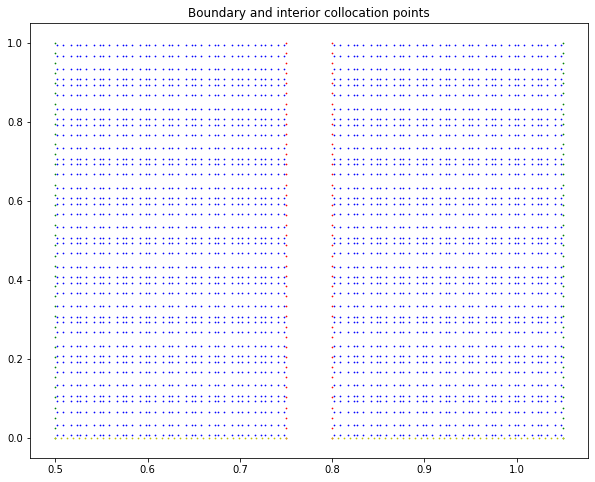

In [37]:
plt.figure(figsize=(10, 8))

plt.scatter(Xint_1[:,0], Xint_1[:,1], s=0.5, c='blue')
plt.scatter(Xbnd_area_1[:,0], Xbnd_area_1[:,1], s=0.5, c='green')
plt.scatter(XInf_area_1[:,0], XInf_area_1[:,1], s=0.5, c='red')
plt.scatter(Xinit_area_1[:,0], Xinit_area_1[:,1], s=0.5, c='y')

plt.scatter(Xint_2[:,0], Xint_2[:,1], s=0.5, c='blue')
plt.scatter(Xbnd_area_2[:,0], Xbnd_area_2[:,1], s=0.5, c='green')
plt.scatter(XInf_area_2[:,0], XInf_area_2[:,1], s=0.5, c='red')
plt.scatter(Xinit_area_2[:,0], Xinit_area_2[:,1], s=0.5, c='y')

plt.title("Boundary and interior collocation points")
plt.show()

In [38]:
class Diffusion(tf.keras.Model):
    def __init__(self, layers, train_op, num_epoch, print_epoch):
        super(Diffusion,self).__init__()
        self.model_layers = layers
        self.train_op = train_op
        self.num_epoch = num_epoch
        self.print_epoch = print_epoch
        self.adam_loss_hist = []
        
    def call(self,X):
        return self.u(X[:,0:1], X[:,1:2])
    
    @tf.function
    def u(self,xPhys,yPhys):
        X = tf.concat([xPhys,yPhys],axis=1)
        X = 2.0 * (X - self.bounds["lb"])/(self.bounds["ub"] - self.bounds["lb"]) - 1.0
        for layer in self.model_layers:
            X = layer(X)
        return X
    
    @tf.function
    def du(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            u_val = self.u(xPhys,yPhys)
        dudx_val = tape.gradient(u_val,xPhys) # c_x
        dudy_val = tape.gradient(u_val,yPhys) # c_t
        del tape
        return dudx_val, dudy_val
    
    @tf.function
    def d2u(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            dudx_val, _ = self.du(xPhys,yPhys) # c_xx
        d2udx2_val = tape.gradient(dudx_val,xPhys)
        del tape
        return d2udx2_val
    
    '''
        Establish the partial derivative of u
    '''
    def du_fc(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            u_val = pred_model_stress(tf.concat([xPhys, yPhys], axis=1))  # get displacement(u) by prediction stress model(e.g. pred_model_stress)
        dudx_fc = tape.gradient(u_val,xPhys)
        del tape
        return dudx_fc
    
    def d2u_fc(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            dudx_fc = self.du_fc(xPhys, yPhys)
        d2udx2_fc = tape.gradient(dudx_fc, xPhys)
        del tape
        return d2udx2_fc
    
    def d3u_fc(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            d2udx2_fc = self.d2u_fc(xPhys, yPhys)
        d3udx3_fc = tape.gradient(d2udx2_fc, xPhys)
        del tape
        return d3udx3_fc
    
    ''' End '''
    
    @tf.function
    def get_loss(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        int_loss, bnd_loss, inf_loss, init_loss = self.get_all_loss(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
        return int_loss + bnd_loss + inf_loss + init_loss
    
    @tf.function
    def get_all_loss(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        
        # 域内损失
        xPhys_1 = Xint_1[:,0:1]
        yPhys_1 = Xint_1[:,1:2]
        xPhys_2 = Xint_2[:,0:1]
        yPhys_2 = Xint_2[:,1:2]
        
        c_val_1 = self.u(xPhys_1,yPhys_1)
        c_val_2 = self.u(xPhys_2,yPhys_2)
        dcdx_1, dcdt_1 = self.du(xPhys_1,yPhys_1)
        dcdx_2, dcdt_2 = self.du(xPhys_2,yPhys_2)
        d2cdx2_1 = self.d2u(xPhys_1,yPhys_1)
        d2cdx2_2 = self.d2u(xPhys_2,yPhys_2)
        # 按照D1进行无量纲化
        if cycle_number == 0:
            f_val_diffusion_1 = xPhys_1 ** 3 * dcdt_1 - xPhys_1 ** 3 * d2cdx2_1 - xPhys_1 ** 2 * dcdx_1
            f_val_diffusion_2 = xPhys_2 ** 3 * dcdt_2 - D_divide * xPhys_2 ** 3 * d2cdx2_2 - D_divide * xPhys_2 ** 2 * dcdx_2
        else:
            # Calculation of partial derivatives  
            f_val_diffusion_1 = xPhys_1 ** 3 * dcdt_1 - xPhys_1 ** 3 * d2cdx2_1 - xPhys_1 ** 2 * dcdx_1
            f_val_diffusion_2 = xPhys_2 ** 3 * dcdt_2 - D_divide * xPhys_2 ** 3 * d2cdx2_2 - D_divide * xPhys_2 ** 2 * dcdx_2
            '''
            u_val_1 = tf.stop_gradient(pred_model_stress(tf.concat[xPhys_1,yPhys_1],axis=1))
            u_val_2 = tf.stop_gradient(pred_model_stress(tf.concat[xPhys_2,yPhys_2],axis=1))
            dudx_1 = self.du_fc(xPhys_1,yPhys_1)
            dudx_2 = self.du_fc(xPhys_2,yPhys_2)
            d2udx2_1 = self.d2u_fc(xPhys_1,yPhys_1)
            d2udx2_2 = self.d2u_fc(xPhys_2,yPhys_2)
            d3udx3_1 = self.d3u_fc(xPhys_1,yPhys_1)
            d3udx3_2 = self.d3u_fc(xPhys_2,yPhys_2)
            
            f_val_diffusion_1 = xPhys_1 ** 3 * dcdt_1 - xPhys_1 ** 3 * d2cdx2_1 - xPhys_1 ** 2 * dcdx_1 + theta1 * c_val * (
                        2.0 * xPhys ** 2 * d2udx2_val - xPhys * dudx_val + u_val - alfa * xPhys ** 2 * dcdx_val + xPhys ** 3 * d3udx3_val - alfa * xPhys ** 3 * d2cdx2_val) + theta * xPhys * dcdx_val * (
                                          xPhys ** 2 * d2udx2_val + xPhys * dudx_val - u_val - alfa * dcdx_val * xPhys ** 2)  # stress limitations
            f_val_diffusion_2 = 
            
            '''
        
        int_loss = tf.reduce_mean(tf.math.square(f_val_diffusion_1)) + tf.reduce_mean(tf.math.square(f_val_diffusion_2))
    
        # 边界损失
        xPhys_bnd_1 = Xbnd_1[:,0:1]
        yPhys_bnd_1 = Xbnd_1[:,1:2]
        xPhys_bnd_2 = Xbnd_2[:,0:1]
        yPhys_bnd_2 = Xbnd_2[:,1:2]
        
        c_val_bnd_1 = self.u(xPhys_bnd_1,yPhys_bnd_1)
        c_val_bnd_2 = self.u(xPhys_bnd_2,yPhys_bnd_2)
        dcdx_val_1,_ = self.du(xPhys_bnd_1,yPhys_bnd_1)
        dcdx_val_2,_ = self.du(xPhys_bnd_2,yPhys_bnd_2)
        
        if cycle_number == 0:
            f_val_bnd_1 = tf.reduce_mean(tf.math.square(dcdx_val_1 - Ybnd_1))
            f_val_bnd_2 = tf.reduce_mean(tf.math.square(D_divide * dcdx_val_2 - Ybnd_2))
        else:
            f_val_bnd_1 = tf.reduce_mean(tf.math.square(dcdx_val_1 - Ybnd_1))
            f_val_bnd_2 = tf.reduce_mean(tf.math.square(D_divide * dcdx_val_2 - Ybnd_2))
        
        bnd_loss = f_val_bnd_1 + f_val_bnd_2
        
        # 界面损失
        c_val_inf_1 = self.call(Xinf_1)
        c_val_inf_2 = self.call(Xinf_2)
        
        xPhys_Inf_1 = Xinf_1[:,0:1]
        yPhys_Inf_1 = Xinf_1[:,1:2]
        xPhys_Inf_2 = Xinf_2[:,0:1]
        yPhys_Inf_2 = Xinf_2[:,1:2]
        
        dcdx_val_inf_1,_ = self.du(xPhys_Inf_1,yPhys_Inf_1)
        dcdx_val_inf_2,_ = self.du(xPhys_Inf_2,yPhys_Inf_2)
        
        # 通量相同
        if cycle_number == 0:
            inf_J1 = D1*(dcdx_val_inf_1)
            inf_J2 = D2*(dcdx_val_inf_2)
        else:
            inf_J1 = D1*(dcdx_val_inf_1)
            inf_J2 = D2*(dcdx_val_inf_2)
        
        inf_loss = tf.reduce_mean(tf.math.square(c_val_inf_1 - c_val_inf_2)) + tf.reduce_mean(tf.math.square(inf_J1 - inf_J2))
        
        # 初始条件损失
        c_val_init_1 = self.call(Xinit_1)
        c_val_init_2 = self.call(Xinit_2)
        
        init_loss = tf.reduce_mean(tf.math.square(c_val_init_1 - Yinit_1)) + tf.reduce_mean(tf.math.square(c_val_init_2 - Yinit_2))
        return int_loss, bnd_loss, inf_loss, init_loss
    
    @tf.function
    def get_grad(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
        g = tape.gradient(L,self.trainable_variables)
        return L, g
    
    def network_learn(self, Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        xmin = tf.math.reduce_min(Xint_1[:, 0])
        ymin = tf.math.reduce_min(Xint_1[:, 1])
        xmax = tf.math.reduce_max(Xint_2[:, 0])
        ymax = tf.math.reduce_max(Xint_2[:, 1])
        self.bounds = {"lb": tf.reshape(tf.stack([xmin, ymin], 0), (1, 2)),
                       "ub": tf.reshape(tf.stack([xmax, ymax], 0), (1, 2))}
        for i in range(self.num_epoch):
            L, g = self.get_grad(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
            self.train_op.apply_gradients(zip(g, self.trainable_variables))
            self.adam_loss_hist.append(L)
            if i % self.print_epoch == 0:
                print("Epoch {} loss: {}".format(i, L))


In [39]:
class Stress_DEM(tf.keras.Model):
    def __init__(self, layers, train_op, num_epoch, print_epoch):
        super(Diffusion,self).__init__()
        self.model_layers = layers
        self.train_op = train_op
        self.num_epoch = num_epoch
        self.print_epoch = print_epoch
        self.adam_loss_hist = []
        
    def call(self,X):
        return self.u(X[:,0:1], X[:,1:2])
    
    @tf.function
    def u(self,xPhys,yPhys):
        X = tf.concat([xPhys,yPhys],axis=1)
        X = 2.0 * (X - self.bounds["lb"])/(self.bounds["ub"] - self.bounds["lb"]) - 1.0
        for layer in self.model_layers:
            X = layer(X)
        return X
    
    @tf.function
    def du(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            u_val = self.u(xPhys,yPhys)
        dudx_val = tape.gradient(u_val,xPhys) # u_x
        dudy_val = tape.gradient(u_val,yPhys) # u_t
        del tape
        return dudx_val, dudy_val
    
    @tf.function
    def d2u(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            dudx_val, _ = self.du(xPhys,yPhys) # u_xx
        d2udx2_val = tape.gradient(dudx_val,xPhys)
        del tape
        return d2udx2_val
    
    '''
        Establish the partial derivative of c
    '''
    def du_fc(self,xPhys,yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            c_val = pred_model(tf.concat([xPhys, yPhys], axis=1))  # get concentration(c) by prediction diffusion model(e.g. pred_model)
        dudx_fc = tape.gradient(c_val,xPhys)
        del tape
        return dudx_fc
    
    def d2u_fc(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            dudx_fc = self.du_fc(xPhys, yPhys)
        d2udx2_fc = tape.gradient(dudx_fc, xPhys)
        del tape
        return d2udx2_fc
    
    def d3u_fc(self, xPhys, yPhys):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xPhys)
            tape.watch(yPhys)
            d2udx2_fc = self.d2u_fc(xPhys, yPhys)
        d3udx3_fc = tape.gradient(d2udx2_fc, xPhys)
        del tape
        return d3udx3_fc
    
    ''' End '''
    
    @tf.function
    def get_loss(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        int_loss, bnd_loss, inf_loss, init_loss = self.get_all_loss(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
        return int_loss + bnd_loss + inf_loss + init_loss
    
    @tf.function
    def get_all_loss(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        
        # 域内损失
        xPhys_1 = Xint_1[:,0:1]
        yPhys_1 = Xint_1[:,1:2]
        xPhys_2 = Xint_2[:,0:1]
        yPhys_2 = Xint_2[:,1:2]
        
        u_val_1 = self.u(xPhys_1,yPhys_1)
        u_val_2 = self.u(xPhys_2,yPhys_2)
        dudx_1, _ = self.du(xPhys_1,yPhys_1)
        dudx_2, _ = self.du(xPhys_2,yPhys_2)
        lam_1 = 1 / (1 - 2 * nu)
        lam_2 = (1 - nu) / (1 + nu)
        lam_3 = nu / (1 + nu)
    
        # 按照E1,D1进行无量纲化
        # material 1
        eps_xx_1 = dudx_1
        eps_yy_1 = tf.divide(u_val_1,xPhys_1)
        c_val_1 = tf.stop_gradient(pred_model(tf.concat([xPhys_1,yPhys_1],axis=1)))
        
        stress_xx_1 = lam_1 * (lam_2 * eps_xx_1 + lam_3 * eps_yy_1)
        stress_yy_1 = lam_1 * (lam_3 * eps_xx_1 + lam_2 * eps_yy_1)
        f_val_diffusion_1 = tf.reduce_sum((0.5 * (eps_xx_1 * stress_xx_1 + eps_yy_1 * stress_yy_1) - lam_1 * alfa * c_val_1 / 3 * (eps_xx_1 + eps_yy_1))*Wint_1)
        
        #material 2
        eps_xx_2 = dudx_2
        eps_yy_2 = tf.divide(u_val_2,xPhys_2)
        c_val_2 = tf.stop_gradient(pred_model(tf.concat([xPhys_2,yPhys_2],axis=1)))
        stress_xx_2 = E_divide * lam_1 * (lam_2 * eps_xx_1 + lam_3 * eps_yy_1)
        stress_yy_2 = E_divide * lam_1 * (lam_3 * eps_xx_1 + lam_2 * eps_yy_1)
        f_val_diffusion_2 = tf.reduce_sum((0.5 * (eps_xx_2 * stress_xx_2 + eps_yy_2 * stress_yy_2) - E_divide * lam_1 * alfa * c_val_2 / 3 * (eps_xx_2 + eps_yy_2))*Wint_2)
        
        int_loss = f_val_diffusion_1 + f_val_diffusion_2
    
        # 边界损失
        xPhys_bnd_1 = Xbnd_1[:,0:1]
        yPhys_bnd_1 = Xbnd_1[:,1:2]
        xPhys_bnd_2 = Xbnd_2[:,0:1]
        yPhys_bnd_2 = Xbnd_2[:,1:2]
        
        u_val_bnd_1 = self.u(xPhys_bnd_1,yPhys_bnd_1)
        u_val_bnd_2 = self.u(xPhys_bnd_2,yPhys_bnd_2)
        dudx_val_1,_ = self.du(xPhys_bnd_1,yPhys_bnd_1)
        dudx_val_2,_ = self.du(xPhys_bnd_2,yPhys_bnd_2)
        
        # material 1
        eps_xx_bnd_1 = dudx_val_1
        eps_yy_bnd_1 = tf.divide(u_val_bnd_1,xPhys_bnd_1)
        c_val_bnd_1 = tf.stop_gradient(pred_model(tf.concat([xPhys_bnd_1, yPhys_bnd_1], axis=1)))
        stress_xx_bnd_1 = lam_1 * (lam_2 * eps_xx_bnd_1 + lam_3 * eps_yy_bnd_1 - alfa * c_val_bnd_1 / 3)
        f_val_bnd_1 = tf.reduce_mean(tf.math.square(stress_xx_bnd_1))
        
        # material 2
        eps_xx_bnd_2 = dudx_val_2
        eps_yy_bnd_2 = tf.divide(u_val_bnd_2,xPhys_bnd_2)
        c_val_bnd_2 = tf.stop_gradient(pred_model(tf.concat([xPhys_bnd_2, yPhys_bnd_2], axis=1)))
        stress_xx_bnd_2 = E_divide * lam_1 * (lam_2 * eps_xx_bnd_2 + lam_3 * eps_yy_bnd_2 - alfa * c_val_bnd_2 / 3)
        f_val_bnd_2 = tf.reduce_mean(tf.math.square(stress_xx_bnd_2))
        
        bnd_loss = f_val_bnd_1 + f_val_bnd_2
        
        # 界面损失
        u_val_inf_1 = self.call(Xinf_1)
        u_val_inf_2 = self.call(Xinf_2)
        
        xPhys_Inf_1 = Xinf_1[:,0:1]
        yPhys_Inf_1 = Xinf_1[:,1:2]
        xPhys_Inf_2 = Xinf_2[:,0:1]
        yPhys_Inf_2 = Xinf_2[:,1:2]
        
        dudx_val_inf_1,_ = self.du(xPhys_Inf_1,yPhys_Inf_1)
        dudx_val_inf_2,_ = self.du(xPhys_Inf_2,yPhys_Inf_2)
        
        # material 1
        eps_xx_Inf_1 = dudx_val_inf_1
        eps_yy_Inf_1 = tf.divide(u_val_inf_1,xPhys_Inf_1)
        c_val_Inf_1 = tf.stop_gradient(pred_model(tf.concat([xPhys_Inf_1, yPhys_Inf_1], axis=1)))
        stress_xx_Inf_1 = lam_1 * (lam_2 * eps_xx_Inf_1 + lam_3 * eps_yy_Inf_1 - alfa * c_val_Inf_1 / 3)
        
        # material 2 
        eps_xx_Inf_2 = dudx_val_inf_2
        eps_yy_Inf_2 = tf.divide(u_val_inf_2,xPhys_Inf_2)
        c_val_Inf_2 = tf.stop_gradient(pred_model(tf.concat([xPhys_Inf_2, yPhys_Inf_2], axis=1)))
        stress_xx_Inf_2 = E_divide * lam_1 * (lam_2 * eps_xx_Inf_2 + lam_3 * eps_yy_Inf_2 - alfa * c_val_Inf_2 / 3)

        inf_loss = tf.reduce_mean(tf.math.square(u_val_inf_1 - u_val_inf_2)) + tf.reduce_mean(tf.math.square(stress_xx_Inf_1 - stress_xx_Inf_2))
        
        # 初始条件损失
        u_val_init_1 = self.call(Xinit_1)
        u_val_init_2 = self.call(Xinit_2)
        
        init_loss = tf.reduce_mean(tf.math.square(u_val_init_1)) + tf.reduce_mean(tf.math.square(u_val_init_2))
        return int_loss, bnd_loss, inf_loss, init_loss
    
    @tf.function
    def get_grad(self,Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
        g = tape.gradient(L,self.trainable_variables)
        return L, g
    
    def network_learn(self, Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number):
        xmin = tf.math.reduce_min(Xint_1[:, 0])
        ymin = tf.math.reduce_min(Xint_1[:, 1])
        xmax = tf.math.reduce_max(Xint_2[:, 0])
        ymax = tf.math.reduce_max(Xint_2[:, 1])
        self.bounds = {"lb": tf.reshape(tf.stack([xmin, ymin], 0), (1, 2)),
                       "ub": tf.reshape(tf.stack([xmax, ymax], 0), (1, 2))}
        for i in range(self.num_epoch):
            L, g = self.get_grad(Xint_1,Xint_2,Yint_1,Yint_2,Wint_1,Wint_2,
                 Xbnd_1,Xbnd_2,Ybnd_1,Ybnd_2,
                 Xinit_1,Xinit_2,Yinit_1,Yinit_2,
                 Xinf_1,Xinf_2,
                 cycle_number)
            self.train_op.apply_gradients(zip(g, self.trainable_variables))
            self.adam_loss_hist.append(L)
            if i % self.print_epoch == 0:
                print("Epoch {} loss: {}".format(i, L))


In [40]:
tf.keras.backend.set_floatx(data_type)
l1 = tf.keras.layers.Dense(50, "tanh")
l2 = tf.keras.layers.Dense(50, "tanh")
l3 = tf.keras.layers.Dense(50, "tanh")
l4 = tf.keras.layers.Dense(50, "tanh")
l5 = tf.keras.layers.Dense(50, "tanh")
l6 = tf.keras.layers.Dense(1, None)
train_op = tf.keras.optimizers.Adam()
num_epoch = 2000
print_epoch = 200
pred_model = Diffusion([l1, l2, l3, l4, l5 ,l6], train_op, num_epoch, print_epoch)

#convert the training data to tensors
Xint_1_tf = tf.convert_to_tensor(Xint_1)
Xint_2_tf = tf.convert_to_tensor(Xint_2)
Yint_1_tf = tf.convert_to_tensor(Yint_1)
Yint_2_tf = tf.convert_to_tensor(Yint_2)
Wint_1_tf = tf.convert_to_tensor(Wint_1)
Wint_2_tf = tf.convert_to_tensor(Wint_2)

Xbnd_1_tf = tf.convert_to_tensor(Xbnd_area_1)
Xbnd_2_tf = tf.convert_to_tensor(Xbnd_area_2)
Ybnd_1_tf = tf.convert_to_tensor(Ybnd_area_1)
Ybnd_2_tf = tf.convert_to_tensor(Ybnd_area_2)

Xinit_1_tf = tf.convert_to_tensor(Xinit_area_1)
Xinit_2_tf = tf.convert_to_tensor(Xinit_area_2)
Yinit_1_tf = tf.convert_to_tensor(Yinit_area_1)
Yinit_2_tf = tf.convert_to_tensor(Yinit_area_2)

XInf_1_tf = tf.convert_to_tensor(XInf_area_1)
XInf_2_tf = tf.convert_to_tensor(XInf_area_2)

In [41]:
# Adam
print("Training (ADAM)...")
t0 = time.time()
pred_model.network_learn(Xint_1_tf,Xint_2_tf,Yint_1_tf,Yint_2_tf,Wint_1_tf,Wint_2_tf,
                 Xbnd_1_tf,Xbnd_2_tf,Ybnd_1_tf,Ybnd_2_tf,
                 Xinit_1_tf,Xinit_2_tf,Yinit_1_tf,Yinit_2_tf,
                 XInf_1_tf,XInf_2_tf,
                 cycle_number)
t1 = time.time()
print("Time taken (ADAM)", t1-t0, "seconds")

Training (ADAM)...
Epoch 0 loss: 5.483606422681974
Epoch 200 loss: 0.027582170874806425
Epoch 400 loss: 0.014628954049758277
Epoch 600 loss: 0.013724699794478941
Epoch 800 loss: 0.013233348608396481
Epoch 1000 loss: 0.012987912123257178
Epoch 1200 loss: 0.012438494959922265
Epoch 1400 loss: 0.01238147659695767
Epoch 1600 loss: 0.01190730053686534
Epoch 1800 loss: 0.012182635695132827
Time taken (ADAM) 270.352019071579 seconds


In [42]:
print("Training (LBFGS)...")

loss_func = tfp_function_factory(pred_model,Xint_1_tf,Xint_2_tf,Yint_1_tf,Yint_2_tf,Wint_1_tf,Wint_2_tf,
                 Xbnd_1_tf,Xbnd_2_tf,Ybnd_1_tf,Ybnd_2_tf,
                 Xinit_1_tf,Xinit_2_tf,Yinit_1_tf,Yinit_2_tf,
                 XInf_1_tf,XInf_2_tf,
                 cycle_number) # 计算模型参数的损失值和梯度，便于BFGS求解
#loss_func = scipy_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf)
# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)#.numpy()
# train the model with BFGS solver
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=loss_func, initial_position=init_params,
          max_iterations=1000, tolerance=1e-14)  
# results = scipy.optimize.minimize(fun=loss_func, x0=init_params, jac=True, method='L-BFGS-B',
#                 options={'disp': None, 'maxls': 50, 'iprint': -1, 
#                 'gtol': 1e-12, 'eps': 1e-12, 'maxiter': 50000, 'ftol': 1e-12, 
#                 'maxcor': 50, 'maxfun': 50000})
# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
loss_func.assign_new_model_parameters(results.position)
#loss_func.assign_new_model_parameters(results.x)
t2 = time.time()
print("Time taken (LBFGS)", t2-t1, "seconds")
print("Time taken (all)", t2-t0, "seconds")

Training (LBFGS)...
Iter: 200 loss: 0.010629469669153492
Iter: 400 loss: 0.010303969845180398
Iter: 600 loss: 0.010086110497480948
Iter: 800 loss: 0.0098644997787357
Iter: 1000 loss: 0.009363365845685305
Iter: 1200 loss: 0.0086952513068258956
Iter: 1400 loss: 0.0082953880802957673
Iter: 1600 loss: 0.0073036169368785485
Iter: 1800 loss: 0.00707284278377477
Iter: 2000 loss: 0.0069045978266978666
Iter: 2200 loss: 0.0066515606754677711
Iter: 2400 loss: 0.0064085514674946022
Iter: 2600 loss: 0.0059695274021229362
Iter: 2800 loss: 0.0055979680029574555
Time taken (LBFGS) 428.02591943740845 seconds
Time taken (all) 698.3779385089874 seconds


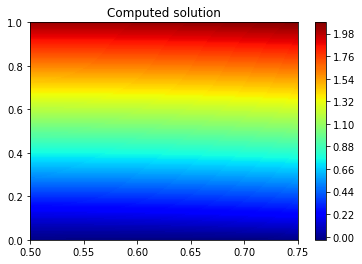

In [69]:
# 预测
# 将测试点*2倍
numPtsUTest = 501
numPtsVTest = 501
xPhysTest_1, yPhysTest_1 = domainGeom_area_1.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1]) # 生成一个均匀分布的内部点网格，包含边界
xPhysTest_2, yPhysTest_2 = domainGeom_area_2.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1]) 
XTest_1 = np.concatenate((xPhysTest_1,yPhysTest_1),axis=1).astype(data_type) # 拼接x,y
XTest_2 = np.concatenate((xPhysTest_2,yPhysTest_2),axis=1).astype(data_type) # 拼接x,y
# XTest = np.concatenate((XTest_1,XTest_2),axis=1)

XTest_tf = tf.convert_to_tensor(XTest_1) # tensor 张量
YTest = pred_model(XTest_tf).numpy()     # 预测 输出y

xPhysTest2D = np.resize(XTest_1[:,0], [numPtsUTest, numPtsVTest])
yPhysTest2D = np.resize(XTest_1[:,1], [numPtsUTest, numPtsVTest])

YTest2D_1 = np.resize(YTest, [numPtsUTest, numPtsVTest])
plt.show()
plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_1, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed solution")
plt.show()

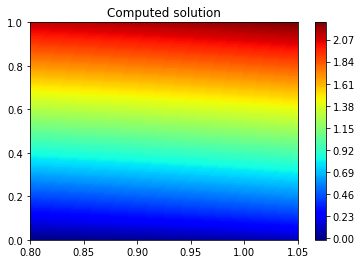

In [70]:
XTest_tf = tf.convert_to_tensor(XTest_2) # tensor 张量
YTest = pred_model(XTest_tf).numpy()     # 预测 输出y
xPhysTest2D = np.resize(XTest_2[:,0], [numPtsUTest, numPtsVTest])
yPhysTest2D = np.resize(XTest_2[:,1], [numPtsUTest, numPtsVTest])
YTest2D_2 = np.resize(YTest, [numPtsUTest, numPtsVTest])
plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_2, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed solution")
plt.show()

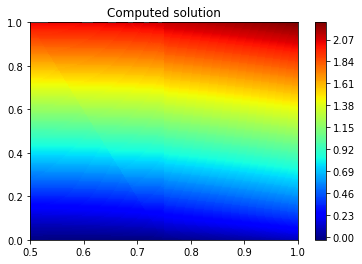

In [71]:
# 预测
# 将测试点*2倍
numPtsUTest = 501
numPtsVTest = 501
xPhysTest_1, yPhysTest_1 = domainGeom_area_1.getUnifIntPts(numPtsUTest, numPtsVTest, [1, 1, 1, 1]) # 生成一个均匀分布的内部点网格，包含边界
xPhysTest_2, yPhysTest_2 = domainGeom_area_2.getUnifIntPts(numPtsUTest, numPtsVTest, [1, 1, 1, 1])
XTest_1 = np.concatenate((xPhysTest_1, yPhysTest_1), axis=1).astype(data_type) # 拼接x,y
XTest_2 = np.concatenate((xPhysTest_2, yPhysTest_2), axis=1).astype(data_type) # 拼接x,y

# 预测区域1
XTest_tf_1 = tf.convert_to_tensor(XTest_1) # tensor 张量
YTest_1 = pred_model(XTest_tf_1).numpy()     # 预测 输出y

# 预测区域2
XTest_tf_2 = tf.convert_to_tensor(XTest_2) # tensor 张量
YTest_2 = pred_model(XTest_tf_2).numpy()     # 预测 输出y

# 合并区域1和区域2的数据
XTest_2[:,0] -= delta # 修正区域2的X坐标偏移以保证连续性
XTest = np.concatenate((XTest_1, XTest_2), axis=0)
YTest = np.concatenate((YTest_1, YTest_2), axis=0)

# 将合并后的数据转换为2D网格
xPhysTest2D = np.resize(XTest[:, 0], [2 * numPtsUTest, numPtsVTest])
yPhysTest2D = np.resize(XTest[:, 1], [2 * numPtsUTest, numPtsVTest])
YTest2D_all = np.resize(YTest, [2 * numPtsUTest, numPtsVTest])

# 绘制计算解
plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_all, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed solution")
plt.show()

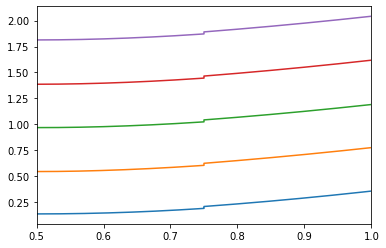

In [73]:
# 绘制各条线
for i in range(50, 500, 100):
    x_line = np.concatenate([xPhysTest2D[i:i+1,:], xPhysTest2D[i+500:i+501,:]], axis=1)
    y_line = np.concatenate([YTest2D_all[i:i+1,:], YTest2D_all[i+500:i+501,:]], axis=1)
    plt.plot(x_line.flatten(), y_line.flatten())

plt.xlim(0.5,1)
plt.show()